In [1]:
# ran in google colab
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 6.4 MB/s 
     |████████████████████████████████| 189 kB 47.8 MB/s 
     |████████████████████████████████| 46 kB 3.5 MB/s 
     |████████████████████████████████| 1.2 MB 39.4 MB/s 
     |████████████████████████████████| 56 kB 6.2 MB/s 
     |████████████████████████████████| 51 kB 400 kB/s 
Mounted at /content/gdrive


In [43]:
from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [3]:
import zipfile
import os
!wget --no-check-certificate \
    "https://github.com/yoheioka/15458_final_project/archive/refs/heads/main.zip" \
    -O "/tmp/15458_final_project.zip"


zip_ref = zipfile.ZipFile('/tmp/15458_final_project.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2021-12-09 22:32:11--  https://github.com/yoheioka/15458_final_project/archive/refs/heads/main.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/yoheioka/15458_final_project/zip/refs/heads/main [following]
--2021-12-09 22:32:11--  https://codeload.github.com/yoheioka/15458_final_project/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/15458_final_project.zip’

/tmp/15458_final_pr     [   <=>              ] 510.01M  20.8MB/s    in 26s     

2021-12-09 22:32:38 (19.3 MB/s) - ‘/tmp/15458_final_project.zip’ saved [534781135]



In [4]:
METRIC = 'long10'
INSTRUMENT = 'EUR_USD'
GRANULARITY = 5
IMAGE_DIR = '/tmp/15458_final_project-main/images_with_volume/%s_%s_%s/' % (
    GRANULARITY, INSTRUMENT, METRIC
)
TRAIN_DIR = IMAGE_DIR + 'train'
TEST_DIR = '/tmp/15458_final_project-main/images_with_volume/%s_%s_%s_test/' % (
    GRANULARITY, INSTRUMENT, METRIC
)

batch_size = 32
img_height = 434
img_width = 422

In [5]:
data = ImageDataLoaders.from_folder(
    IMAGE_DIR,
    valid_pct=0.3,
    size=224,
    bs=32,
    num_workers=8
)

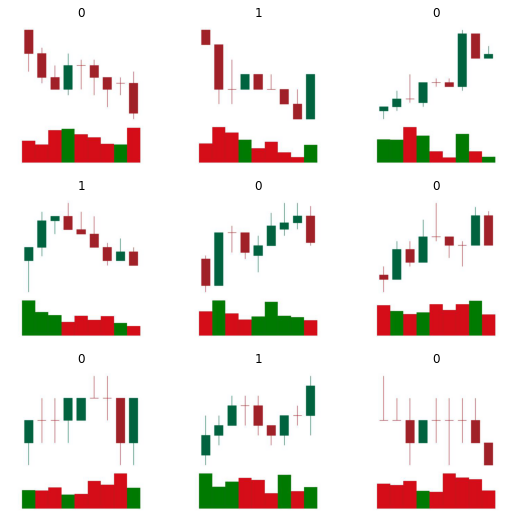

In [6]:
data.show_batch()

In [7]:
# See the number of images in each data set
print(len(data.train_ds), len(data.valid_ds))

39304 16844


In [10]:
metrics = [
    accuracy,
    Precision(average='micro'),
    Recall(average='micro'),
]
learn = cnn_learner(data, models.alexnet, metrics=metrics)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [11]:
learn.fit_one_cycle(4)

SuggestedLRs(valley=1.5848931980144698e-06)

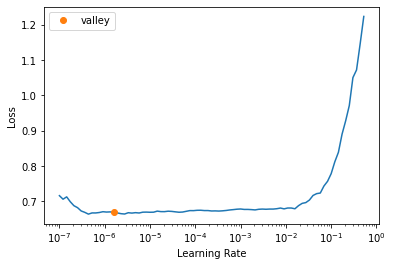

In [12]:
learn.unfreeze()
learn.lr_find()

In [13]:
learn.fit_one_cycle(4, lr_max=slice(10e-6, 10e-5))

In [14]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

dest = Path(base_dir + "15458/models/")

Mounted at /content/gdrive


In [15]:
try:
  dest.mkdir(parents=True, exist_ok=False)
except FileExistsError:
  print ('File Already Exists')
learn.save(dest/'alexnet')

File Already Exists


Path('/content/gdrive/My Drive/fastai-v3/15458/models/alexnet.pth')

In [16]:
learn.load(dest/'alexnet')

In [17]:
test_data = get_image_files(TEST_DIR)

In [18]:
results = []  # timestamp, day, actual, prediction 
for i, test_d in enumerate(test_data):
  if (i % 1000 == 0):
    print(i)
  splits = str(test_d).split('/')
  time = int(splits[-1].replace('.jpg', ''))
  day = int(time / 86400) * 86400
  actual = int(splits[-2])
  prediction = int(learn.predict(test_d)[0])
  results.append([time, day, actual, prediction])

0


1000


2000


3000


4000


5000


6000


7000


8000


9000


10000


11000


12000


13000


14000


15000


16000


17000


18000


In [23]:
results_dict = [
    {
      'time': r[0],
      'day': r[1],
      'actual': r[2],
      'prediction': r[3]
    } for r in results
]
df_results = pd.DataFrame(results_dict)

In [25]:
print(
    df_results[(df_results['actual'] == 0) & (df_results['prediction'] == 0)].shape[0],
    df_results[(df_results['actual'] == 0) & (df_results['prediction'] == 1)].shape[0],
    df_results[(df_results['actual'] == 1) & (df_results['prediction'] == 0)].shape[0],
    df_results[(df_results['actual'] == 1) & (df_results['prediction'] == 1)].shape[0]
)

9964 781 7241 609


In [32]:
df_results['trade_success'] = (df_results['actual'] == 1) & (df_results['prediction'] == 1)
df_results['trade_fail'] = (df_results['actual'] == 0) & (df_results['prediction'] == 1)

In [61]:
trades_by_day = df_results.groupby('day').sum()
trades_by_day['return'] = (trades_by_day['trade_success'] - trades_by_day['trade_fail']) * 1000
trades_by_day.index =  pd.to_datetime(trades_by_day.index, unit='s')
trades_by_day['cum_return'] =  trades_by_day['return'].cumsum()

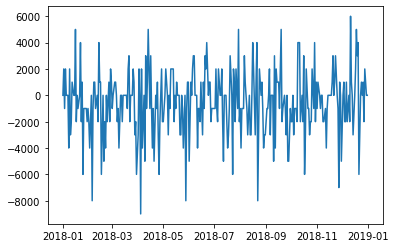

In [58]:
plt.plot(trades_by_day.index, trades_by_day['return'])
plt.show()

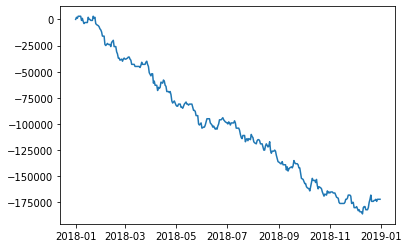

In [63]:
plt.plot(trades_by_day.index, trades_by_day['cum_return'])
plt.show()